In [1]:
import pandas as pd
import numpy as np
#import config as cfg
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold
from xgboost import XGBRegressor
from xgboost import plot_importance

<h2>1. Product Clicks </h2>

In [2]:
df_clicks =  pd.read_csv("Tables/prod_product_viewed.csv")

In [3]:
df_clicks = df_clicks[['id', 'brand', 'category', 'event', 'event_text', 'name', 'original_timestamp', 'timestamp',\
                       'price', 'product_id', 'price']]
df_clicks

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,price
0,ajs-next-a0fa08e1d278e7cf29e4180f5942fdf7,PROARTE,Brush Sets,product_viewed,Product Viewed,PROARTE Pro Brush - (28Pcs),2022-12-28 12:56:45.816 UTC,2022-12-28 12:56:47.366 UTC,17000.0,7524675.0,17000.0
1,ajs-next-b79169f9cf90ebc151114ce3bd88be27,Wet n Wild,Sponges & Applicators,product_viewed,Product Viewed,Wet N Wild Makeup Sponge Applicator,2022-12-28 12:40:56.101 UTC,2022-12-28 12:40:56.843 UTC,509.0,7530242.0,509.0
2,ajs-next-86a9f92af2427dc3c59169b745f47aed,Ustraa,Colognes & After Shaves,product_viewed,Product Viewed,Ustraa After Dark Cologne Perfume - (100ml),2023-02-19 08:02:30.538 UTC,2023-02-19 08:02:31.199 UTC,611.0,7504965.0,611.0
3,ajs-next-838df329be126b305b37301cfbf7fcdd,The Face Shop,Sheet Masks,product_viewed,Product Viewed,The Face Shop Real Nature Green Tea Face Sheet...,2023-02-19 12:22:25.262 UTC,2023-02-19 12:22:25.271 UTC,100.0,7538505.0,100.0
4,ajs-next-5380d8638d3f205d3fde9a67931a0931,Colorbar,Eyebrow Enhancer,product_viewed,Product Viewed,Colorbar Stunning Brow Mini Eyebrow Pencil - 0...,2023-03-12 05:45:04.578 UTC,2023-03-12 05:45:04.433 UTC,239.0,7502178.0,239.0
...,...,...,...,...,...,...,...,...,...,...,...
107451,ajs-next-2eb55cb4f1abf0cae66057482d011459,AND,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,And Love Muse EDP & Pretty Vogue Mist - (2Pcs),2023-02-10 01:08:54.045 UTC,2023-02-10 01:08:54.041 UTC,1804.0,7539766.0,1804.0
107452,936F9F8D-F71C-4069-8867-956D328AF4E1,Dolce&Gabbana,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Dolce & Gabbana Pour Femme Intense EDP (50ml),2023-01-24 09:27:25.3 UTC,2023-01-24 09:27:25.884 UTC,7850.0,7545438.0,7850.0
107453,BC1CE98C-02FF-4D59-9374-72F7A2A1EF2A,Carolina Herrera,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Carolina Herrera Very Good Girl Eau De Parfum ...,2023-03-22 16:14:44.032 UTC,2023-03-22 16:14:44.271 UTC,8000.0,7506000.0,8000.0
107454,364BC995-6653-48DF-9BE1-E6768C4CD4EA,Paco Rabanne,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Paco Rabanne Pure XS for Her Eau De Parfum (50ml),2023-01-18 04:39:41.583 UTC,2023-01-18 04:39:41.833 UTC,5270.0,7506583.0,5270.0


In [4]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107456 entries, 0 to 107455
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  107456 non-null  object 
 1   brand               105503 non-null  object 
 2   category            105503 non-null  object 
 3   event               107456 non-null  object 
 4   event_text          107456 non-null  object 
 5   name                105476 non-null  object 
 6   original_timestamp  107456 non-null  object 
 7   timestamp           107456 non-null  object 
 8   price               105739 non-null  float64
 9   product_id          105484 non-null  float64
 10  price               105739 non-null  float64
dtypes: float64(3), object(8)
memory usage: 9.0+ MB


<h2>Brand-wise Clicks</h2>

In [5]:
df_clicks_brand = df_clicks.copy()
df_clicks_brand['brand'].value_counts()

Colorbar               7429
M.A.C                  7286
Lakme                  6414
Estee Lauder           6162
Maybelline New York    5965
                       ... 
Osia Osia                 1
Biorigin                  1
Taali Foods               1
Pepsodent                 1
Elizabeth Taylor          1
Name: brand, Length: 653, dtype: int64

In [6]:
df_clicks_brand['clicks'] = np.zeros(len(df_clicks_brand))
df_clicks_brand = df_clicks_brand.groupby('brand', as_index=False).agg({'clicks': 'count'})
df_clicks_brand.sort_values('clicks', ascending=False)

,brand,clicks
138,Colorbar,7429
357,M.A.C,7286
334,Lakme,6414
191,Estee Lauder,6162
380,Maybelline New York,5965
...,...,...
418,Naughty Girl,1
488,Purearth,1
54,Azafran Organics,1
134,Colgate,1


<h2>Category-wise clicks<h2>

In [7]:
brand_to_category_dict = dict(zip(df_clicks['brand'], df_clicks['category']))
brand_to_category_dict

{'PROARTE': 'Eye Brush',
 'Wet n Wild': 'Liquid Lipstick',
 'Ustraa': 'Mens Deodorants & Roll-Ons',
 'The Face Shop': 'Body Wash & Shower Gel',
 'Colorbar': 'Body Wash & Shower Gel',
 'Jaquline USA': 'Liquid Lipstick',
 'Dot & Key': 'Serums & Essences',
 'ASA beauty': 'Highlighters',
 'AXE': 'Mens Deodorants & Roll-Ons',
 'SUGAR Cosmetics': 'Serums & Essences',
 'mCaffeine': 'Body Wash & Shower Gel',
 'Wild Stone': 'Mens Deodorants & Roll-Ons',
 'Power Gummies': 'Multivitamins',
 'PAC': 'Face Moisturizer',
 'Simply Nam': 'Liquid Lipstick',
 'Vitro Naturals': 'Body Wash & Shower Gel',
 'Vaseline': 'Body Wash & Shower Gel',
 'Miss Claire': 'Liquid Lipstick',
 'Gillette': 'Razors & Cartridges',
 'Ikonic Professional': 'Hair Curling Irons',
 'Truefitt & Hill': 'Face Moisturiser',
 'Unpa': 'Serums & Essences',
 'Pink Woolf': 'Face Wash',
 'Plum': 'Womens Perfumes (EDT & EDP)',
 'CLINIQUE': 'Womens Perfumes (EDT & EDP)',
 'The Moms Co.': 'Serums & Essences',
 'The Man Company': 'Mens Deodora

In [8]:
len(brand_to_category_dict.keys())

654

In [9]:
df_clicks_category = df_clicks.copy()
df_clicks_category['clicks'] = np.zeros(len(df_clicks_category))
df_clicks_category = df_clicks_category.groupby('category', as_index=False).agg({'clicks': 'count'})
df_clicks_category.sort_values('clicks', ascending=False)

,category,clicks
134,Lipstick,13248
91,Foundation,12619
135,Liquid Lipstick,6897
153,Mens Perfumes (EDT & EDP),4529
162,Nail Polish,3616
...,...,...
25,Beauty & Personal Care,1
196,Stretch Mark Creams & Oil,1
4,Anti-Cellulite Creams,1
167,Omega 3 & Fish Oil,1


<h2> 2. Order Completed </h2>

In [10]:
df_order_completed = pd.read_csv("Tables/prod_order_completed.csv")
df_order_completed = df_order_completed[df_order_completed['products'].isnull() == False]
df_order_completed

,id,event,event_text,original_timestamp,timestamp,products
0,ajs-next-353b3bbae250ca5e75ae35dbc4e9bbad,order_completed,Order Completed,2023-02-26 18:00:09.277000 UTC,2023-02-26 18:00:09.718000 UTC,"[{""brand"":""Estee Lauder"",""name"":""Estee Lauder ..."
1,ajs-next-edc545249f1bd71743b85eaddd8fae4c,order_completed,Order Completed,2022-08-24 10:19:02.284000 UTC,2022-08-24 10:19:03.117000 UTC,"[{""item_brand"":""Elle 18"",""item_id"":7503415,""it..."
2,ajs-next-1601c54194fd585e0cc7032c5f94f0bc,order_completed,Order Completed,2022-12-28 05:02:13.159000 UTC,2022-12-28 05:02:13.681000 UTC,"[{""brand"":""M.A.C"",""name"":""M.A.C Matte Lipstick..."
3,ajs-next-cd28c1aa890b9e7cd325c6b56e101375,order_completed,Order Completed,2023-01-31 17:02:06.200000 UTC,2023-01-31 17:02:06.554000 UTC,"[{""brand"":""Streax"",""name"":""Streax Insta Shampo..."
4,ajs-next-dfda63d40e976232f0c494c550cfc30b,order_completed,Order Completed,2023-03-08 15:08:17.092000 UTC,2023-03-08 15:08:18.351000 UTC,"[{""brand"":""Keya Seth Aromatherapy"",""name"":""Key..."
...,...,...,...,...,...,...
3302,EF5E4D5F-5BAF-4D67-BA86-5E69F9FCFCAE,order_completed,Order Completed,2023-01-09 12:04:27.215000 UTC,2023-01-09 12:04:27.738000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."
3303,C100E5B9-5DC3-4679-A418-29B72A129055,order_completed,Order Completed,2023-01-07 17:05:19.838000 UTC,2023-01-07 17:05:19.968000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."
3304,18D0E75E-211E-484A-917A-B44BEE0B4149,order_completed,Order Completed,2023-01-09 12:03:57.569000 UTC,2023-01-09 12:03:58.046000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."
3305,87C72BEE-1C7A-40BB-A173-A1E1811BD08B,order_completed,Order Completed,2023-01-09 12:22:07.610000 UTC,2023-01-09 12:22:45.692000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."


In [11]:
df_order_completed.iloc[2, 5]

'[{"brand":"M.A.C","name":"M.A.C Matte Lipstick - Please Me (3g)","price":1750,"product_id":7526540,"quantity":1},{"brand":"Estee Lauder","name":"Estee Lauder Advanced Night Repair Synchronized Multi-Recovery Complex - (50ml)","price":8250,"product_id":7532193,"quantity":1}]'

In [12]:
eval(df_order_completed.iloc[110, 5])

[{'brand': 'M.A.C',
  'category': 'Face Primer',
  'coupon': 'TIRAAPPRIL30 coupon applied',
  'currency': 'INR',
  'name': 'M.A.C Prep + Prime Fix+ - Original (100ml)',
  'price': 1950,
  'product_id': '7519188',
  'quantity': 1},
 {'brand': 'Plum',
  'category': 'Skin Cleanser',
  'coupon': 'TIRAAPPRIL30 coupon applied',
  'currency': 'INR',
  'name': 'Plum E-Luminence Simply Supple Cleansing Balm - (90g)',
  'price': 545,
  'product_id': '7523924',
  'quantity': 1},
 {'brand': 'Plum',
  'category': 'Hair Oil',
  'coupon': 'TIRAAPPRIL30 coupon applied',
  'currency': 'INR',
  'name': 'Plum Olive & Macadamia Nutri-Shield Pre-Shampoo Hair Oil - (90ml)',
  'price': 650,
  'product_id': '7528428',
  'quantity': 1},
 {'brand': 'Paco Rabanne',
  'category': 'Mens Perfumes (EDT & EDP)',
  'coupon': 'TIRAAPPRIL30 coupon applied',
  'currency': 'INR',
  'name': 'Paco Rabanne Olympea Intense Eau De Parfum (80ml)',
  'price': 7200,
  'product_id': '7506350',
  'quantity': 1},
 {'brand': 'Minimal

In [13]:
df_order_completed = pd.concat([pd.DataFrame(eval(x)) for x in df_order_completed['products']], \
                               keys=df_order_completed['original_timestamp']).reset_index(level=1, drop=True).reset_index()
df_order_completed

,original_timestamp,brand,name,price,product_id,quantity,item_brand,item_id,item_name,category,coupon,currency,category_id,image_url,size,item_price,item_quantity
0,2023-02-26 18:00:09.277000 UTC,Estee Lauder,Estee Lauder Advanced Night Repair Synchronize...,540.0,7532189,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-24 10:19:02.284000 UTC,NaN,NaN,NaN,NaN,NaN,Elle 18,7503415.0,Elle18 Color Pop Matte Lip Color - W12 Mauve D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-28 05:02:13.159000 UTC,M.A.C,M.A.C Matte Lipstick - Please Me (3g),1750.0,7526540,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-12-28 05:02:13.159000 UTC,Estee Lauder,Estee Lauder Advanced Night Repair Synchronize...,8250.0,7532193,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-31 17:02:06.200000 UTC,Streax,Streax Insta Shampoo Hair Colour - 3 Dark Brow...,25.0,7545612,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5685,2023-01-09 12:04:27.215000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
5686,2023-01-07 17:05:19.838000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
5687,2023-01-09 12:03:57.569000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
5688,2023-01-09 12:22:07.610000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN


In [14]:
df_order_completed = df_order_completed.fillna('0')
for i, row in df_order_completed.iterrows():
    if (row['brand'] == '0'):
        row['brand'] = row['item_brand']
    if (row['name'] == '0'):
        row['name'] = row['item_name']
    if (row['product_id'] == '0'):
        row['product_id'] = row['item_id']
    if (row['category'] == '0'):
        if (row['brand'] in brand_to_category_dict.keys()):
            row['category'] = brand_to_category_dict[row['brand']]
    if (row['price'] == '0'):
        row['price'] = row['item_price']
    if (row['quantity'] == '0'):
        row['quantity'] = row['item_quantity']

In [15]:
df_order_completed.drop(['item_brand', 'item_id', 'item_name', 'coupon', 'currency', 'category_id', 'image_url', 'size', 'item_price', 'item_quantity'], axis=1, inplace=True)

In [16]:
df_order_completed

,original_timestamp,brand,name,price,product_id,quantity,category
0,2023-02-26 18:00:09.277000 UTC,Estee Lauder,Estee Lauder Advanced Night Repair Synchronize...,540.0,7532189,2.0,Womens Perfumes (EDT & EDP)
1,2022-08-24 10:19:02.284000 UTC,Elle 18,Elle18 Color Pop Matte Lip Color - W12 Mauve D...,0,7503415.0,0,Liquid Lipstick
2,2022-12-28 05:02:13.159000 UTC,M.A.C,M.A.C Matte Lipstick - Please Me (3g),1750.0,7526540,1.0,Face Moisturizer
3,2022-12-28 05:02:13.159000 UTC,Estee Lauder,Estee Lauder Advanced Night Repair Synchronize...,8250.0,7532193,1.0,Womens Perfumes (EDT & EDP)
4,2023-01-31 17:02:06.200000 UTC,Streax,Streax Insta Shampoo Hair Colour - 3 Dark Brow...,25.0,7545612,1.0,Hair Serum
...,...,...,...,...,...,...,...
5685,2023-01-09 12:04:27.215000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
5686,2023-01-07 17:05:19.838000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
5687,2023-01-09 12:03:57.569000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
5688,2023-01-09 12:22:07.610000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color


In [17]:
df_order_completed['price'] = df_order_completed['price'].astype(float)
df_order_completed['quantity'] = df_order_completed['quantity'].astype(float)

df_order_completed['quantity'] = df_order_completed['quantity'].apply(lambda x: 1 if x == 0 else x)
df_order_completed['category'] = df_order_completed['category'].apply(lambda x: 'not set' if x == '0' else x)
df_order_completed

,original_timestamp,brand,name,price,product_id,quantity,category
0,2023-02-26 18:00:09.277000 UTC,Estee Lauder,Estee Lauder Advanced Night Repair Synchronize...,540.0,7532189,2.0,Womens Perfumes (EDT & EDP)
1,2022-08-24 10:19:02.284000 UTC,Elle 18,Elle18 Color Pop Matte Lip Color - W12 Mauve D...,0.0,7503415.0,1.0,Liquid Lipstick
2,2022-12-28 05:02:13.159000 UTC,M.A.C,M.A.C Matte Lipstick - Please Me (3g),1750.0,7526540,1.0,Face Moisturizer
3,2022-12-28 05:02:13.159000 UTC,Estee Lauder,Estee Lauder Advanced Night Repair Synchronize...,8250.0,7532193,1.0,Womens Perfumes (EDT & EDP)
4,2023-01-31 17:02:06.200000 UTC,Streax,Streax Insta Shampoo Hair Colour - 3 Dark Brow...,25.0,7545612,1.0,Hair Serum
...,...,...,...,...,...,...,...
5685,2023-01-09 12:04:27.215000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
5686,2023-01-07 17:05:19.838000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
5687,2023-01-09 12:03:57.569000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
5688,2023-01-09 12:22:07.610000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color


In [18]:
df_order_completed.sort_values('quantity', ascending=False)

,original_timestamp,brand,name,price,product_id,quantity,category
2634,2023-02-16 17:41:05.721000 UTC,Dove,Dove Cream Beauty Bathing Bar Soap - (50g),27.0,7547386,100.0,Soaps
2439,2023-01-03 06:02:50.101000 UTC,Biotique,Biotique Basil & Parsley Revitalizing Bathing ...,60.0,7500872,44.0,Body Wash & Shower Gel
2037,2023-01-04 12:48:45.364000 UTC,Vitro Naturals,Vitro I Am Natural Premium Gulab Jal (Rose Wat...,179.0,7527858,17.0,Mist
3129,2023-01-19 14:59:40.696000 UTC,Blue Heaven,Blue Heaven Instant Nail Paint Remover (28ml),40.5,7537691,17.0,Liquid Lipstick
3238,2023-03-22 20:11:16.156000 UTC,Estee Lauder,Estee Lauder Nutritious Super Pomegranate Radi...,3000.0,7524005,16.0,Skin Cleanser
...,...,...,...,...,...,...,...
1979,2023-03-19 06:27:27.087000 UTC,Lakme,Lakme Blush & Glow Lemon Freshness Gel Face Wa...,175.0,7551364,1.0,Serums & Essences
1978,2023-03-19 06:27:27.087000 UTC,Lakme,Lakme Sun Expert SPF 30 Ultra Matte Lotion (10...,359.0,7546957,1.0,Serums & Essences
1977,2023-03-11 06:02:55.218000 UTC,Minimalist,Minimalist 2% Salicylic Acid + LHA Cleanser Re...,284.0,7524004,1.0,Serums & Essences
1976,2023-03-11 06:02:55.218000 UTC,Himalaya,Himalaya Purifying Neem Face Wash (100ml),150.0,7521074,1.0,Lotions & Cream


<h2>Brand-wise</h2>

In [19]:
df_order_completed_brand = df_order_completed.copy()

In [20]:
df_order_completed_brand['no_of_unique_purchases'] = np.zeros(len(df_order_completed_brand))

df_grouped = df_order_completed_brand.groupby('brand', as_index=False).agg({'price':'sum', 'quantity':'sum', 'no_of_unique_purchases': 'count'})
df_grouped.rename(columns={'quantity':'no_of_purchases'}, inplace=True)
df_grouped.sort_values(by='no_of_unique_purchases', ascending=False, inplace=True)
df_grouped

,brand,price,no_of_purchases,no_of_unique_purchases
163,Lakme,100311.54,382.0,352
73,Colorbar,50252.30,279.0,263
194,Maybelline New York,96092.45,236.0,212
112,Garnier,11995.95,245.0,207
246,Plum,67432.35,189.0,181
...,...,...,...,...
264,Rexona,38.00,1.0,1
263,Revolution Pro,850.00,1.0,1
162,Lacoste,4500.00,1.0,1
261,Renewcell,1099.00,1.0,1


In [21]:
df_grouped[df_grouped['brand'] == 'Dove']

,brand,price,no_of_purchases,no_of_unique_purchases
89,Dove,12698.44,201.0,91


In [22]:
df_order_completed_brand = df_grouped.copy()

<h2>Category wise</h2>

In [23]:
df_order_completed_category = df_order_completed.copy()

In [24]:
df_order_completed_category['no_of_unique_purchases'] = np.zeros(len(df_order_completed_category))

df_grouped = df_order_completed_category.groupby('category', as_index=False).agg({'price':'sum', 'quantity':'sum', 'no_of_unique_purchases': 'count'})
df_grouped.rename(columns={'quantity':'no_of_purchases'}, inplace=True)
df_grouped.sort_values(by='no_of_unique_purchases', ascending=False, inplace=True)
df_grouped

,category,price,no_of_purchases,no_of_unique_purchases
124,Serums & Essences,464036.59,1140.0,1059
24,Body Wash & Shower Gel,199738.92,802.0,675
97,Liquid Lipstick,195315.89,665.0,589
50,Face Moisturizer,310635.58,350.0,301
146,Womens Perfumes (EDT & EDP),465384.11,364.0,300
...,...,...,...,...
113,Moustache Oil,249.00,1.0,1
114,Multivitamins,975.00,1.0,1
25,Body Wash & Soaps,265.00,1.0,1
120,Pre & Post Shaves,199.00,1.0,1


In [25]:
df_order_completed_category = df_grouped.copy()

<h2> 3. Adds to Wishlist </h2>

In [26]:
df_wishlist = pd.read_csv('Tables/prod_adds_to_wishlist.csv')
df_wishlist

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,quantity
0,ajs-next-015b7af6596d763141f3d46941181c03,Colorbar,Hand Creams,product_added_to_wishlist,Product Added to Wishlist,Colorbar Toast To Tahiti Fruit Drop Hand Cream...,2022-08-18 04:49:25.199 UTC,2022-08-18 04:49:25.534 UTC,275.0,7504904.0,1.0
1,ajs-next-3c228cfd2f01ea106b9334a279c7ad2b,India Grooming Club,Shavers,product_added_to_wishlist,Product Added to Wishlist,India Grooming Club Black Shaving Razor Handle...,2023-03-06 03:03:23.175 UTC,2023-03-06 03:03:23.144 UTC,16000.0,7521080.0,1.0
2,ajs-next-6f9ab2addfcee447d343fca05b7e8f1f,Vega,Mani-Pedi Tools & Kits,product_added_to_wishlist,Product Added to Wishlist,"set of Foot care, (PM-03)",2023-03-06 07:43:28.6 UTC,2023-03-06 07:43:28.605 UTC,NaN,7513281.0,1.0
3,ajs-next-64cd4a9906319b038a2cb26402866a2a,Gillette,Razors & Cartridges,product_added_to_wishlist,Product Added to Wishlist,Gillette Mach 3 Turbo Manual Shaving Razor Bla...,2023-02-25 11:07:47.504 UTC,2023-02-25 11:07:48.719 UTC,NaN,7547314.0,1.0
4,ajs-next-11fc7950c2e75f7c009cb6b57be395fb,L'Oreal Paris,Hair Colour,product_added_to_wishlist,Product Added to Wishlist,"L'Oreal Paris Casting Creme Gloss Hair Color, ...",2023-02-26 17:54:36.813 UTC,2023-02-26 17:54:37.215 UTC,NaN,7500061.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
17386,8DD2C8BF-02B3-4FC7-A316-80FBD1C20096,Dove,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Dove Original Deodorant Roll On (50ml),2023-02-02 05:36:59.426 UTC,2023-02-02 05:36:59.61 UTC,220.0,7537511.0,1.0
17387,ajs-next-cf9f70a38cfee45eb521566714b65b7d,Antonio Banderas,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Antonio Banderas Blue Seduction for Women Deod...,2023-01-20 09:35:11.579 UTC,2023-01-20 09:35:12.191 UTC,NaN,7506565.0,1.0
17388,EE89C4EF-8BF7-4984-9851-BD2A9B638C0F,Ajmal,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Ajmal Shadow Homme & Sacred Love Deodorant Spr...,2023-02-16 16:29:36.695 UTC,2023-02-16 16:29:37.063 UTC,327.0,7516334.0,1.0
17389,ajs-next-f227259e9202a58c277f5b1d293768e4,Nivea,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Nivea Women Fresh Natural Deodorant Roll On (5...,2023-02-13 09:19:44.375 UTC,2023-02-13 09:19:44.676 UTC,172.0,7516982.0,1.0


<h2>Brand wise</h2>

In [27]:
df_wishlist_brand = df_wishlist.copy()

In [28]:
df_wishlist_brand['no_of_adds_to_wishlist'] = np.zeros(len(df_wishlist_brand))
df_grouped = df_wishlist_brand.groupby('brand', as_index=False)[['category', 'no_of_adds_to_wishlist', 'price']].\
    agg({'price': 'sum', 'no_of_adds_to_wishlist': 'count'}).sort_values('no_of_adds_to_wishlist', ascending= False)
df_grouped

,brand,price,no_of_adds_to_wishlist
110,Colorbar,1092163.0,1686
271,M.A.C,1330501.0,893
288,Maybelline New York,318828.0,585
149,Estee Lauder,1739285.0,505
253,Lakme,115849.0,480
...,...,...,...
346,Paese Cosmetics,1999.0,1
343,PROARTE,0.0,1
154,Fabessentials by Fabindia,375.0,1
156,Fair & Lovely,72.0,1


In [29]:
df_wishlist_brand = df_grouped.copy()

<h2>Category Wise</h2>

In [30]:
df_wishlist_category = df_wishlist.copy()

In [31]:
df_wishlist_category['no_of_adds_to_wishlist'] = np.zeros(len(df_wishlist_category))
df_grouped = df_wishlist_category.groupby('category', as_index=False)[['category', 'no_of_adds_to_wishlist', 'price']].\
    agg({'price': 'sum', 'no_of_adds_to_wishlist': 'count'}).sort_values('no_of_adds_to_wishlist', ascending= False)
df_grouped

,category,price,no_of_adds_to_wishlist
92,Foundation,1646078.0,1628
148,Lipstick,768997.0,1135
149,Liquid Lipstick,319832.0,613
170,Mens Perfumes (EDT & EDP),1630509.0,599
51,Concealer,436173.0,543
...,...,...,...
211,Shower Gels and Body Wash,0.0,1
100,Glimmer,39.0,1
213,Skin Brightening,0.0,1
101,Grooming Kits,0.0,1


In [32]:
df_wishlist_category = df_grouped.copy()

<h2> 4. Adds to Cart </h2>

In [33]:
df_cart = pd.read_csv('tables/prod_adds_to_cart.csv')
df_cart

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,quantity
0,ajs-next-c38fff6fb4d8b3f7d4e45f8575b28546,Gemblue Biocare,Scrubs & Exfoliators,product_added,Product Added,Gemblue Biocare De-Tan Scrub - (500ml),2023-03-08 17:22:17.928 UTC,2023-03-08 17:22:19.833 UTC,200.0,7531140.0,1.0
1,ajs-next-218771062abce857b0a4177287076d20,Lakme,Loose Powder,product_added,Product Added,Lakme Rose Face Powder with Sunscreen - Warm P...,2023-03-08 13:45:03.046 UTC,2023-03-08 13:45:04.22 UTC,314.0,7540496.0,2.0
2,ajs-next-49b830a1cc58005e618b6dfce45cafbb,Maybelline New York,Eyebrow Enhancer,product_added,Product Added,Maybelline New York Define & Blend Brow Pencil...,2023-03-08 04:12:10.713 UTC,2023-03-08 04:12:12.233 UTC,279.0,7540746.0,1.0
3,ajs-next-a2dd98b12f39e38d225acd4a43f3964a,Insight Cosmetics,Highlighters,product_added,Product Added,Insight Cosmetics Highlighter - Angelic Beauty...,2023-03-08 08:01:05.288 UTC,2023-03-08 08:01:05.593 UTC,99.0,7511278.0,1.0
4,ajs-next-6c873beeae834de5a180eec6f84b73c5,The Man Company,Beard Serum,product_added,Product Added,The Man Company Caffeine Beard Growth Serum (3...,2023-02-27 08:19:23.885 UTC,2023-02-27 08:19:23.917 UTC,345.0,7536622.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
60768,ajs-next-d5774566662c83f93c577ee3e70f7445,Plum,Womens Deodorants & Roll-Ons,product_added,Product Added,Plum Bodylovin Feelin So Rose De-Odorizing Pit...,2023-03-14 10:25:17.699 UTC,2023-03-14 10:25:17.729 UTC,258.0,7536073.0,1.0
60769,ajs-next-3610c7e8d444c8f403fe07fe566bdfc3,Plum,Womens Deodorants & Roll-Ons,product_added,Product Added,Plum Bodylovin Feelin So Rose De-Odorizing Pit...,2023-02-18 02:42:25.654 UTC,2023-02-18 02:42:25.673 UTC,345.0,7536073.0,1.0
60770,F1FCD8E3-B0B0-4E74-9C9C-34496D231C23,Ajmal,Womens Deodorants & Roll-Ons,product_added,Product Added,Ajmal Wisal Parfum Deodorant (200ml),2023-01-24 08:10:04.715 UTC,2023-01-24 08:10:05.111 UTC,183.0,7537453.0,1.0
60771,ajs-next-5fb21d2b04c78406e41998b80d8e547a,Dove,Womens Deodorants & Roll-Ons,product_added,Product Added,Dove Original Deodorant - (150ml),2023-03-08 06:39:35.573 UTC,2023-03-08 06:39:36.12 UTC,180.0,7547395.0,1.0


<h2>Brand Wise</h2>

In [34]:
df_cart_brand = df_cart.copy()
df_cart_brand['no_of_adds_to_cart'] = np.zeros(len(df_cart_brand))
df_cart_brand = df_cart_brand.groupby('brand', as_index=False)[['category', 'price', 'quantity', 'no_of_adds_to_cart']]\
    .agg({'price': 'sum', 'quantity': 'sum', 'no_of_adds_to_cart': 'count'}).sort_values('no_of_adds_to_cart', ascending=False)
df_cart_brand

,brand,price,quantity,no_of_adds_to_cart
124,Colorbar,16729213.0,23728.0,5966
321,M.A.C,27211463.0,15276.0,3781
341,Maybelline New York,5622087.0,15624.0,2295
300,Lakme,649599.0,2126.0,1767
169,Estee Lauder,53270491.0,8957.0,1701
...,...,...,...,...
436,RAWNATURE,699.0,1.0,1
431,QOD Professional,1500.0,1.0,1
427,Priveda,399.0,1.0,1
157,ECOVANI,325.0,1.0,1


<h2>Category Wise</h2>

In [35]:
df_cart_category = df_cart.copy()
df_cart_category['no_of_adds_to_cart'] = np.zeros(len(df_cart_category))
df_cart_category = df_cart_category.groupby('category', as_index=False)[['category', 'price', 'quantity', 'no_of_adds_to_cart']]\
    .agg({'price': 'sum', 'quantity': 'sum', 'no_of_adds_to_cart': 'count'}).sort_values('no_of_adds_to_cart', ascending=False)
df_cart_category

,category,price,quantity,no_of_adds_to_cart
87,Foundation,17401078.0,21392.0,5727
131,Lipstick,8244609.0,9695.0,4373
44,Concealer,4120724.0,6563.0,2031
148,Mens Perfumes (EDT & EDP),8067051.0,2304.0,1860
75,Face Primer,22133244.0,13256.0,1853
...,...,...,...,...
53,Epilators,995.0,1.0,1
60,Eye Makeup Remover,2900.0,1.0,1
79,Facial Cleansing Brushes,360.0,1.0,1
161,Omega 3 & Fish Oil,1399.0,1.0,1


<h2> Joining All tables </h2>

In [36]:
# Brand Tables
df_joined_brand = df_clicks_brand.merge(df_order_completed_brand, on='brand', how='inner', suffixes=('', '_order_completes')).\
                            merge(df_wishlist_brand, on='brand', how='inner', suffixes=('', '_wishlist'))
df_joined_brand = df_joined_brand.merge(df_cart_brand, on='brand', how='inner', suffixes=('', '_cart'))
df_joined_brand

,brand,clicks,price,no_of_purchases,no_of_unique_purchases,price_wishlist,no_of_adds_to_wishlist,price_cart,quantity,no_of_adds_to_cart
0,23 Yards,18,398.00,2.0,2,1578.0,11,9152.0,33.0,27
1,4711,29,0.00,1.0,1,12830.0,12,37746.0,53.0,41
2,A Fragrance Story,57,1877.00,3.0,3,7524.0,14,20374.0,28.0,27
3,AND,227,7509.00,4.0,4,224850.0,131,590738.0,313.0,271
4,AXE,94,2159.00,20.0,18,958.0,19,51155.0,369.0,110
...,...,...,...,...,...,...,...,...,...,...
315,YC,7,613.10,2.0,2,655.0,3,1866.0,6.0,6
316,Yardley London,8,254.00,1.0,1,254.0,1,2032.0,8.0,8
317,Yves Rocher,275,19620.00,17.0,15,75780.0,43,939395.0,645.0,394
318,ZM Zayn & Myza,96,2204.90,6.0,6,3519.0,25,19711.0,83.0,60


In [37]:
df_joined_brand.drop(['price', 'price_wishlist', 'price_cart', 'quantity'], axis=1, inplace=True)

df_joined_brand.sort_values('no_of_unique_purchases', ascending=False)

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
152,Lakme,6414,382.0,352,480,1767
71,Colorbar,7429,279.0,263,1686,5966
180,Maybelline New York,5965,236.0,212,585,2295
108,Garnier,673,245.0,207,162,798
229,Plum,2391,189.0,181,434,1526
...,...,...,...,...,...,...
258,Skin Elements,33,1.0,1,1,7
44,Biotop Professional,22,1.0,1,2,13
256,Simply Nam,178,1.0,1,6,24
255,Simple,29,1.0,1,3,16


In [38]:
df_ml = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_unique_purchases']].copy()
df_ml

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_unique_purchases
0,23 Yards,18,11,27,2
1,4711,29,12,41,1
2,A Fragrance Story,57,14,27,3
3,AND,227,131,271,4
4,AXE,94,19,110,18
...,...,...,...,...,...
315,YC,7,3,6,2
316,Yardley London,8,1,8,1
317,Yves Rocher,275,43,394,15
318,ZM Zayn & Myza,96,25,60,6


In [39]:
normalize_cols = ['clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_unique_purchases']

for column in normalize_cols:
    df_ml[column] = (df_ml[column] - df_ml[column].min()) / (df_ml[column].max() - df_ml[column].min())    

df_ml

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_unique_purchases
0,23 Yards,0.002289,0.005935,0.004359,0.002849
1,4711,0.003770,0.006528,0.006706,0.000000
2,A Fragrance Story,0.007539,0.007715,0.004359,0.005698
3,AND,0.030425,0.077151,0.045264,0.008547
4,AXE,0.012520,0.010682,0.018273,0.048433
...,...,...,...,...,...
315,YC,0.000808,0.001187,0.000838,0.002849
316,Yardley London,0.000942,0.000000,0.001174,0.000000
317,Yves Rocher,0.036887,0.024926,0.065884,0.039886
318,ZM Zayn & Myza,0.012789,0.014243,0.009891,0.014245


<AxesSubplot:>

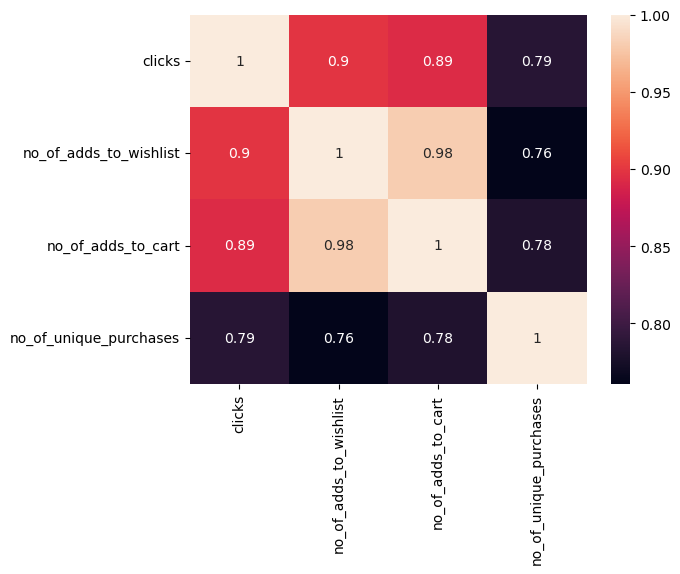

In [40]:
sns.heatmap(df_ml.corr(), annot=True)

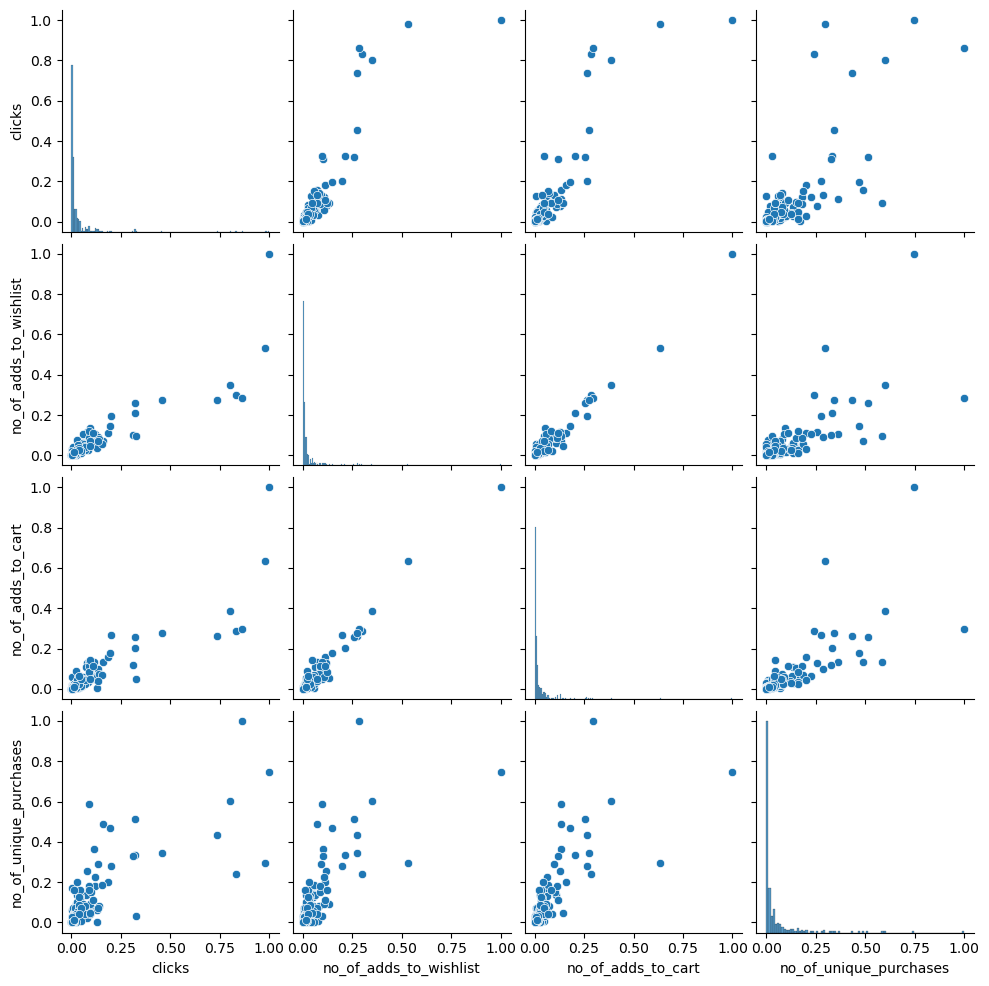

In [41]:
sns.pairplot(df_ml) 

In [42]:
from sklearn.model_selection import train_test_split
import sklearn
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold
from xgboost import XGBRegressor
from xgboost import plot_importance


In [43]:
X = df_ml[['clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart']]
Y = df_ml['no_of_unique_purchases']

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                      test_size = 0.3, random_state = 123)

<h2>Fitting XGBRegressor with Cross Validation</h2>

In [45]:
xgb_reg = XGBRegressor(verbosity=0)
xgb_reg.fit(x_train, y_train)
train_score = xgb_reg.score(x_train, y_train)

In [46]:
train_score

0.9998275418498919

<h3>Evaluating with Negative Root mean squared error</h3>

In [47]:
cv = KFold(n_splits=10, shuffle=True, random_state=123)
final_scores = cross_val_score(xgb_reg, X, Y, cv=cv, scoring='neg_root_mean_squared_error')
abs(final_scores).mean()

0.0791579853156531

In [48]:
final_scores

array([-0.03080588, -0.09130246, -0.09486877, -0.16419976, -0.02518885,
       -0.05173789, -0.08072343, -0.06129134, -0.03501303, -0.15644844])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

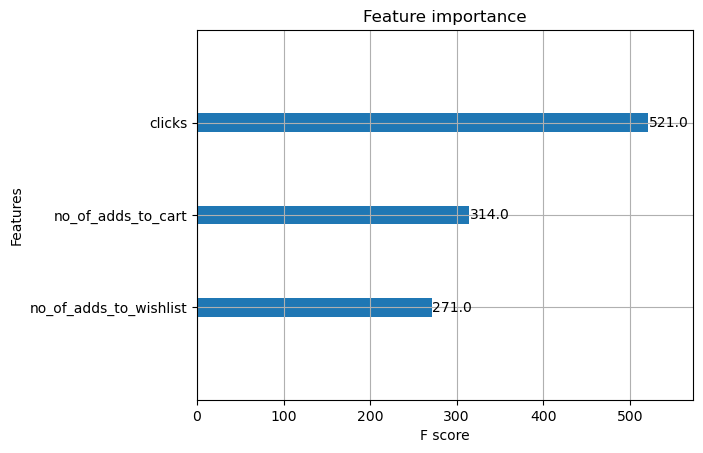

In [49]:
plot_importance(xgb_reg)

In [50]:
xgb_reg.get_booster().get_score(importance_type='weight')

{'clicks': 521.0, 'no_of_adds_to_wishlist': 271.0, 'no_of_adds_to_cart': 314.0}

<h3>Evaluating with second method</h3>

In [51]:
xgb_reg.fit(x_train, y_train, eval_metric='rmse', eval_set=[(x_train, y_train), (x_test, y_test)], verbose=True)

[0]	validation_0-rmse:0.32879	validation_1-rmse:0.33056
[1]	validation_0-rmse:0.23256	validation_1-rmse:0.23753
[2]	validation_0-rmse:0.16518	validation_1-rmse:0.17591
[3]	validation_0-rmse:0.11805	validation_1-rmse:0.13446
[4]	validation_0-rmse:0.08531	validation_1-rmse:0.10944
[5]	validation_0-rmse:0.06256	validation_1-rmse:0.09542
[6]	validation_0-rmse:0.04706	validation_1-rmse:0.08756
[7]	validation_0-rmse:0.03661	validation_1-rmse:0.08328
[8]	validation_0-rmse:0.02938	validation_1-rmse:0.08139
[9]	validation_0-rmse:0.02503	validation_1-rmse:0.08021
[10]	validation_0-rmse:0.02111	validation_1-rmse:0.07984
[11]	validation_0-rmse:0.01924	validation_1-rmse:0.08016
[12]	validation_0-rmse:0.01806	validation_1-rmse:0.08022
[13]	validation_0-rmse:0.01717	validation_1-rmse:0.08045
[14]	validation_0-rmse:0.01616	validation_1-rmse:0.08042
[15]	validation_0-rmse:0.01571	validation_1-rmse:0.08046
[16]	validation_0-rmse:0.01459	validation_1-rmse:0.08067
[17]	validation_0-rmse:0.01411	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

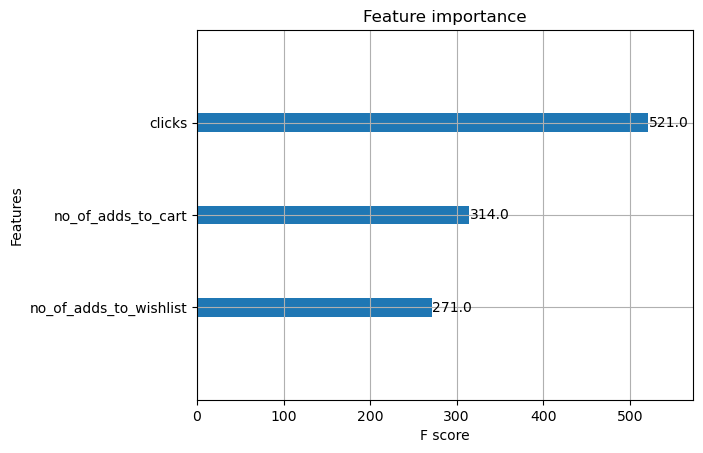

In [52]:
plot_importance(xgb_reg)

In [53]:
f_importance = xgb_reg.get_booster().get_score(importance_type='weight')

f_importance

{'clicks': 521.0, 'no_of_adds_to_wishlist': 271.0, 'no_of_adds_to_cart': 314.0}

In [54]:
importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')
importance_df.columns = ['weights']
importance_df

,weights
clicks,521.0
no_of_adds_to_wishlist,271.0
no_of_adds_to_cart,314.0


In [55]:
importance_df['weights'] = importance_df['weights']/importance_df['weights'].sum()
importance_df

,weights
clicks,0.471067
no_of_adds_to_wishlist,0.245027
no_of_adds_to_cart,0.283906


<h2>Caclulating Popularity Score based the weights</h2>

In [56]:
df_joined_brand

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
0,23 Yards,18,2.0,2,11,27
1,4711,29,1.0,1,12,41
2,A Fragrance Story,57,3.0,3,14,27
3,AND,227,4.0,4,131,271
4,AXE,94,20.0,18,19,110
...,...,...,...,...,...,...
315,YC,7,2.0,2,3,6
316,Yardley London,8,1.0,1,1,8
317,Yves Rocher,275,17.0,15,43,394
318,ZM Zayn & Myza,96,6.0,6,25,60


In [57]:
df_X = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']].copy()

for column in ['clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']:
    df_X[column] = (df_X[column] - df_X[column].min()) / (df_X[column].max() - df_X[column].min())    

df_X

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_purchases
0,23 Yards,0.002289,0.005935,0.004359,0.002625
1,4711,0.003770,0.006528,0.006706,0.000000
2,A Fragrance Story,0.007539,0.007715,0.004359,0.005249
3,AND,0.030425,0.077151,0.045264,0.007874
4,AXE,0.012520,0.010682,0.018273,0.049869
...,...,...,...,...,...
315,YC,0.000808,0.001187,0.000838,0.002625
316,Yardley London,0.000942,0.000000,0.001174,0.000000
317,Yves Rocher,0.036887,0.024926,0.065884,0.041995
318,ZM Zayn & Myza,0.012789,0.014243,0.009891,0.013123


In [58]:
w_purchase = 0.35
w_clicks = importance_df.loc['clicks', 'weights'] * 0.65
w_wishlist = importance_df.loc['no_of_adds_to_wishlist', 'weights'] * 0.65
w_cart = importance_df.loc['no_of_adds_to_cart', 'weights'] * 0.65

w_purchase + w_clicks + w_wishlist + w_cart

1.0

In [59]:
w_cart

0.1845388788426763

In [60]:
df_popularity_fin = df_X
df_popularity_fin['popularity_score'] = (df_X['no_of_purchases'] * w_purchase + df_X['clicks'] * w_clicks + df_X['no_of_adds_to_wishlist'] * w_wishlist + df_X['no_of_adds_to_cart'] * w_cart)/(w_purchase + w_clicks + w_wishlist + w_cart)

In [61]:
df_popularity_fin.sort_values('popularity_score', ascending=False)

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_purchases,popularity_score
71,Colorbar,1.000000,1.000000,1.000000,0.729659,0.905381
152,Lakme,0.863355,0.284273,0.296060,1.000000,0.714264
165,M.A.C,0.980749,0.529377,0.633697,0.406824,0.643942
180,Maybelline New York,0.802908,0.346588,0.384577,0.616798,0.587894
96,Estee Lauder,0.829429,0.299110,0.284996,0.496063,0.527819
...,...,...,...,...,...,...
286,The Tribe Concepts,0.001212,0.000000,0.000335,0.000000,0.000433
178,Matra,0.000673,0.000593,0.000503,0.000000,0.000393
143,Kora Organics,0.001077,0.000000,0.000000,0.000000,0.000330
24,BH Cosmetics,0.000269,0.000593,0.000335,0.000000,0.000239
